In [1]:
# Vissulization of the original dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression


In [3]:
# Loading the dataset
file_path = 'dataset.xlsx'
data = pd.read_excel(file_path)

# Checking if the data is correctly loaded
print(data.head())  # Displaying first few rows of the data to


   rotation    radiation  L1
0        10  6905.481345  20
1        20  6909.377830  20
2        30  6889.812835  20
3        40  6901.790795  20
4        50  6904.916806  20


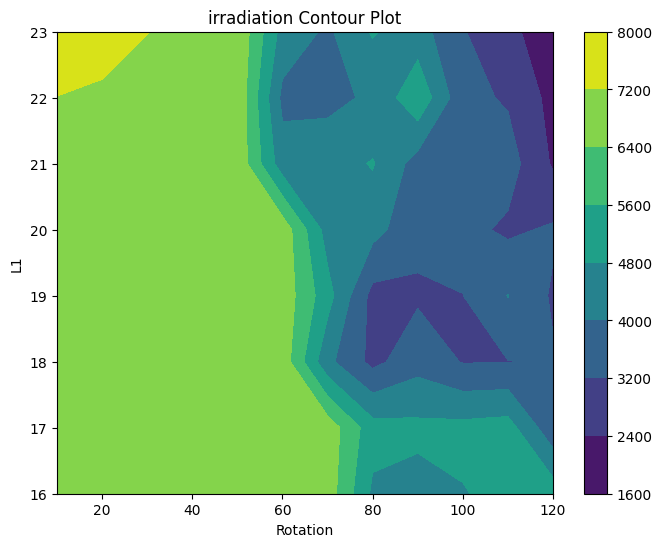

In [4]:
from scipy.interpolate import griddata

# Creating a grid for L1 and rotation values
rotation_grid, L1_grid = np.meshgrid(np.arange(10, 121, 10), np.arange(16, 24, 1))

# Interpolating the radiation values
radiation_grid = griddata(
    (data['rotation'], data['L1']), data['radiation'],
    (rotation_grid, L1_grid), method='cubic'
)

# Visualize the grid
plt.figure(figsize=(8, 6))
cp = plt.contourf(rotation_grid, L1_grid, radiation_grid, cmap='viridis')
plt.colorbar(cp)
plt.xlabel('Rotation')
plt.ylabel('L1')
plt.title('irradiation Contour Plot')
plt.show()


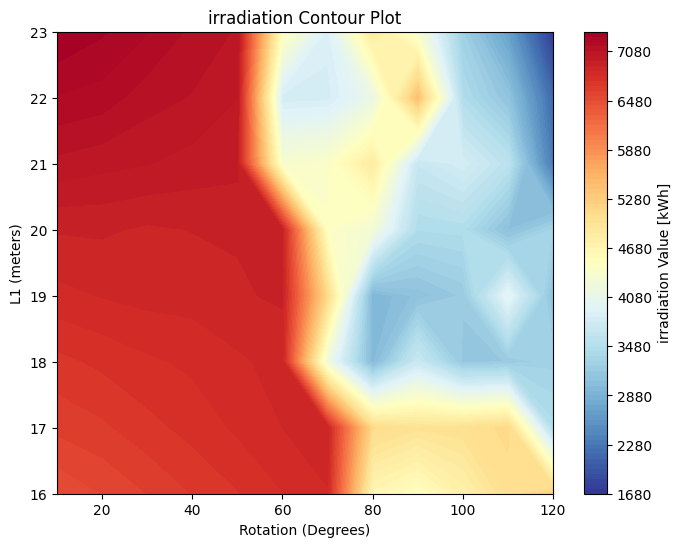

In [5]:
# Visualizing the grid with a continuous color gradient
plt.figure(figsize=(8, 6))

# Creating the contour plot using a continuous color map
cp = plt.contourf(rotation_grid, L1_grid, radiation_grid, levels=100, cmap='RdYlBu_r')  

# Adding a colorbar with labels
cbar = plt.colorbar(cp)
cbar.set_label('irradiation Value [kWh]')  

# Customizing labels and title
plt.xlabel('Rotation (Degrees)')
plt.ylabel('L1 (meters)')
plt.title('irradiation Contour Plot')

# Show the plot
plt.show()


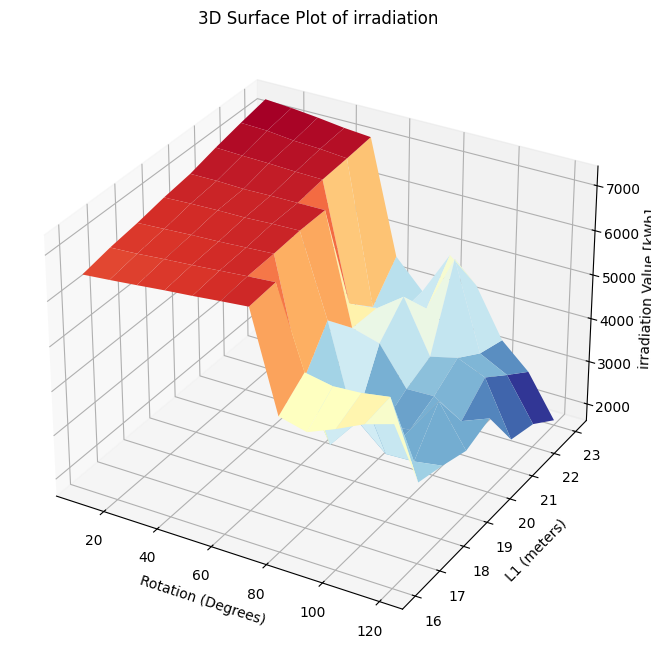

In [6]:
from mpl_toolkits.mplot3d import Axes3D

# Preparing the data for 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Creating the 3D surface plot
ax.plot_surface(rotation_grid, L1_grid, radiation_grid, cmap='RdYlBu_r', edgecolor='none')

# Adding labels and title
ax.set_xlabel('Rotation (Degrees)')
ax.set_ylabel('L1 (meters)')
ax.set_zlabel('irradiation Value [kWh]')
ax.set_title('3D Surface Plot of irradiation')

plt.show()


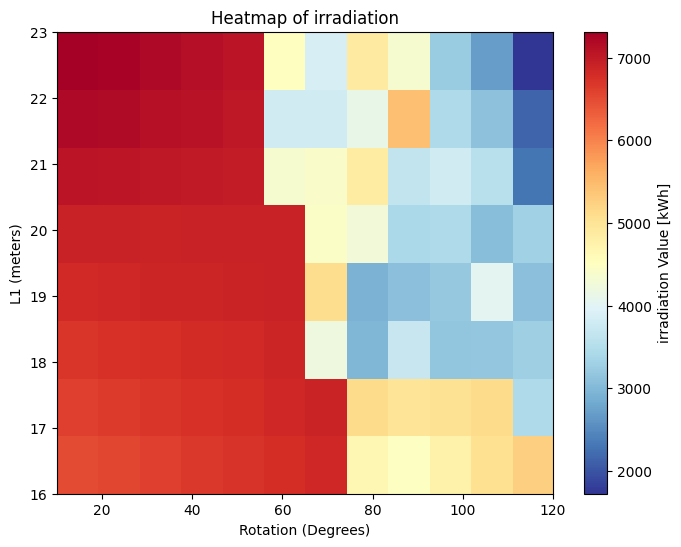

In [7]:
# Heatmap
plt.figure(figsize=(8, 6))
plt.imshow(radiation_grid, cmap='RdYlBu_r', extent=[10, 120, 16, 23], origin='lower', aspect='auto')
plt.colorbar(label='irradiation Value [kWh]')
plt.xlabel('Rotation (Degrees)')
plt.ylabel('L1 (meters)')
plt.title('Heatmap of irradiation')

plt.show()


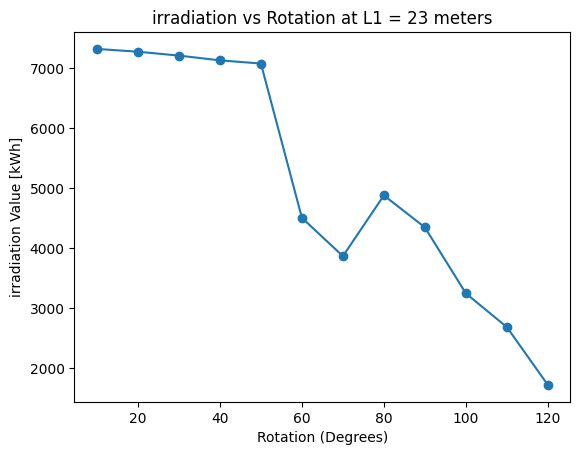

In [8]:
# Example: Line plot for varying rotation at a fixed L1 (e.g., L1 = 16)
L1_fixed = 23
radiation_at_L1 = data[data['L1'] == L1_fixed]

plt.plot(radiation_at_L1['rotation'], radiation_at_L1['radiation'], marker='o')
plt.xlabel('Rotation (Degrees)')
plt.ylabel('irradiation Value [kWh]')
plt.title(f'irradiation vs Rotation at L1 = {L1_fixed} meters')

plt.show()


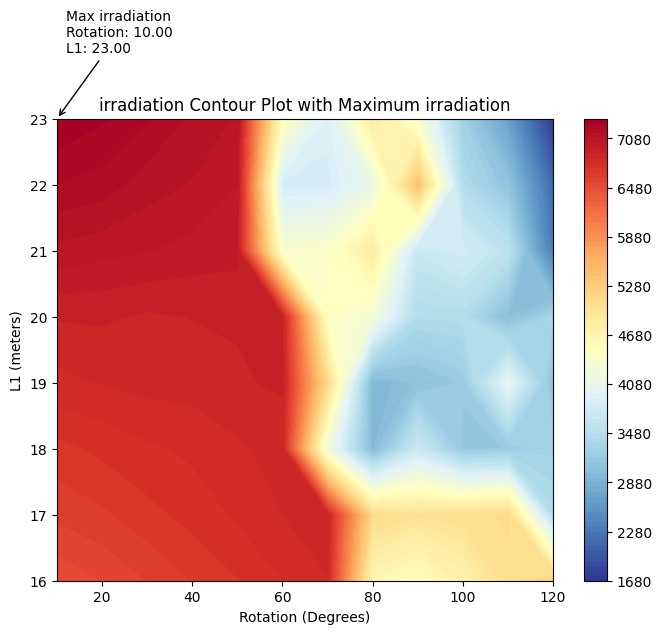

In [9]:
# Finding the max radiation
max_radiation = np.max(radiation_grid)
max_radiation_index = np.unravel_index(np.argmax(radiation_grid), radiation_grid.shape)
max_rotation = rotation_grid[max_radiation_index]
max_L1 = L1_grid[max_radiation_index]

# Ploting with annotations
plt.figure(figsize=(8, 6))
cp = plt.contourf(rotation_grid, L1_grid, radiation_grid, levels=100, cmap='RdYlBu_r')
plt.colorbar(cp)
plt.xlabel('Rotation (Degrees)')
plt.ylabel('L1 (meters)')
plt.title('irradiation Contour Plot with Maximum irradiation')

# Annotating the point of maximum radiation
plt.annotate(f'Max irradiation\nRotation: {max_rotation:.2f}\nL1: {max_L1:.2f}', 
             xy=(max_rotation, max_L1), 
             xycoords='data', 
             xytext=(max_rotation+2, max_L1+1), 
             textcoords='data',
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10)

plt.show()


In [10]:
#Since we have two input variables and one output, their combinations can be visualized in a 3D space. 
# The goal here is to build an emulator that fits an optimal surface through these points, allowing us to represent the entire dataset.

#Our simulated data are limited to rotation angles from 10° to 120° in 10° increments, and to L1 values from 16 m to 23 m in 1 m increments. 
# Although we only sampled those discrete combinations, intermediate values still exist and can be estimated by the fitted surface.

#To achieve this, we began with a second-degree (quadratic) surface equation. We evaluated its performance using Mean Squared Error (MSE) and 𝑅2.
# Then, we performed cross-validation with higher-degree polynomial surfaces. By comparing the 
#𝑅2 scores, we identified the model degree that best represents our data.

In [11]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

# Load your Excel file
df = pd.read_excel("dataset.xlsx")

# Extract feature matrix X and target y
X = df[["rotation", "L1"]].values
y = df["radiation"].values


In [12]:
# Generating [1, rotation, L1, rotation², rotation·L1, L1²] for each row
poly = PolynomialFeatures(degree=2, include_bias=True)
X2 = poly.fit_transform(X)


In [13]:
model = LinearRegression()
model.fit(X2, y)


LinearRegression()

In [14]:
def predict_surface(rotation, L1):
    # pack into the same shape, transform, then predict
    pts = np.column_stack([rotation.ravel(), L1.ravel()])
    pts2 = poly.transform(pts)
    return model.predict(pts2).reshape(rotation.shape)

In [15]:
# Building a fine grid over the defined bounds
r_lin = np.linspace(10, 120, 1111)     # step ≈0.1 degree
L_lin = np.linspace(16, 23, 701)       # step ≈0.01

R, L = np.meshgrid(r_lin, L_lin)
Z = predict_surface(R, L)

# Locating the maximum point
idx = np.unravel_index(np.argmax(Z), Z.shape)
r_opt, L_opt = R[idx], L[idx]
rad_opt = Z[idx]

print(f"Optimal rotation = {r_opt:.2f}°, L1 = {L_opt:.2f} → irradiation ≈ {rad_opt:.1f}")


Optimal rotation = 10.00°, L1 = 23.00 → irradiation ≈ 7865.7


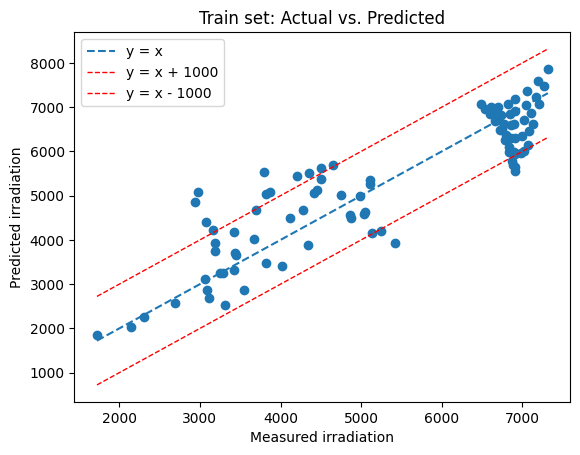

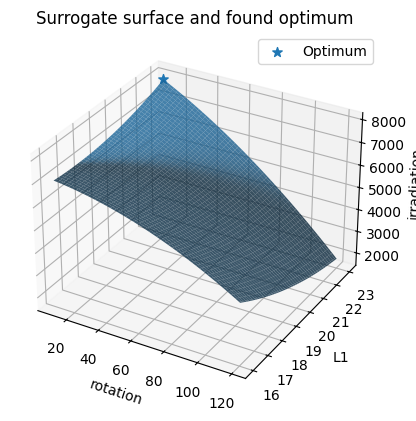

In [16]:
# Plotting a scatter of actual vs. predicted values
y_pred_train = model.predict(X2)
plt.figure()
plt.scatter(y, y_pred_train)
plt.plot([y.min(), y.max()], [y.min(), y.max()], linestyle="--", label="y = x")

# Adding 3 dashed lines: y = x, y = x + 1000, y = x - 1000
line = np.linspace(y.min(), y.max(), 100)
plt.plot(line, line + 1000, 'r--', linewidth=1, label="y = x + 1000")
plt.plot(line, line - 1000, 'r--', linewidth=1, label="y = x - 1000")
plt.xlabel("Measured irradiation")
plt.ylabel("Predicted irradiation")
plt.title("Train set: Actual vs. Predicted")
plt.legend()
plt.show()

# Creating a surface plot with the optimum point marked
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(R, L, Z, edgecolor="none", alpha=0.8)
ax.scatter(r_opt, L_opt, rad_opt, s=50, marker="*", label="Optimum")
ax.set_xlabel("rotation")
ax.set_ylabel("L1")
ax.set_zlabel("irradiation")
ax.legend()
plt.title("Surrogate surface and found optimum")
plt.show()

In [17]:
# getting the equation of the surface -------------------------------------------------

In [18]:
# Applying PolynomialFeatures with degree 2 and including bias
# Fitting the polynomial to X
feature_names = poly.get_feature_names_out(["rotation", "L1"])
print(feature_names)

['1' 'rotation' 'L1' 'rotation^2' 'rotation L1' 'L1^2']


In [19]:
['1', 'rotation', 'L1', 'rotation^2', 'rotation L1', 'L1^2']


['1', 'rotation', 'L1', 'rotation^2', 'rotation L1', 'L1^2']

In [20]:
coeffs = model.coef_       
intercept = model.intercept_

for name, c in zip(feature_names, coeffs):
    print(f"{name:>12s} : {c:.6g}")
print(f"{'intercept':>12s} : {intercept:.6g}")

           1 : 0
    rotation : 60.5121
          L1 : -946.506
  rotation^2 : -0.162797
 rotation L1 : -4.08447
        L1^2 : 28.2463
   intercept : 15043.6


In [21]:
# Creating an array like ["1", "rotation", "L1", "rotation²", "rotation·L1", "L1²", …]
feature_names
coeffs = model.coef_
intercept = model.intercept_


In [22]:
# Building the equation string
terms = []
for name, c in zip(feature_names, coeffs):
    if name == "1":
        continue
  # Choosing the sign for each term
    sign = "+" if c >= 0 else "-"
    coeff_str = f"{abs(c):.6g}"

   # shortening variable names
    var_str = name.replace("rotation", "r")
    terms.append(f" {sign} {coeff_str}*{var_str}")

# Assembling the full equation with the intercept
equation = f"f(r,L1) = {intercept:.6g}" + "".join(terms)

# Printing the result
print("\nComplete equation:\n")
print(equation)



Complete equation:

f(r,L1) = 15043.6 + 60.5121*r - 946.506*L1 - 0.162797*r^2 - 4.08447*r L1 + 28.2463*L1^2


In [23]:
def surface_eq(r, L):
    return (
        15043.6
        + 60.5121 * r
        - 946.506 * L
        - 0.162797 * r**2
        - 4.08447 * r * L
        + 28.2463 * L**2
    )

# Performing a quick check at one of the original points
# Verifying closeness to the measured value (~6905)


#  Computing the quadratic-surface prediction at (20, 20)
quad_pred = surface_eq(20, 20)

# Looking up the measured radiation in df
measured_row = df.loc[
    (df["rotation"] == 20) & (df["L1"] == 20),
    "radiation"
]
if not measured_row.empty:
    measured_rad = measured_row.values[0]
else:
    measured_rad = None

# 3) Print both for comparison
print(f"Quadratic-surface prediction at (20°, 20 m): {quad_pred:.4f} W/m²")
if measured_rad is not None:
    print(f"Measured radiation              at (20°, 20 m): {measured_rad:.4f} W/m²")
else:
    print("No matching measured row found for (20°, 20 m).")

Quadratic-surface prediction at (20°, 20 m): 6923.3352 W/m²
Measured radiation              at (20°, 20 m): 6909.3778 W/m²


In [24]:
#Calculating SSE---------------------------------

In [25]:
# Using the mean radiation as the baseline prediction
y_mean = np.mean(y)

# Computing the sum of squared errors for the baseline
sse_initial = np.sum((y - y_mean)**2)
print(f"Initial (intercept-only) SSE: {sse_initial:.2f}")


Initial (intercept-only) SSE: 257355185.19


In [26]:
# Generating predictions on the training set
y_pred = model.predict(X2)

# Calculating the sum of squared errors after fitting
sse_optimized = np.sum((y - y_pred)**2)
print(f"Optimized (polynomial) SSE: {sse_optimized:.2f}")


Optimized (polynomial) SSE: 50971691.48


In [27]:
reduction = 100*(sse_initial - sse_optimized)/sse_initial
print(f"SSE reduced by {reduction:.1f}% after fitting the polynomial surface.")


SSE reduced by 80.2% after fitting the polynomial surface.


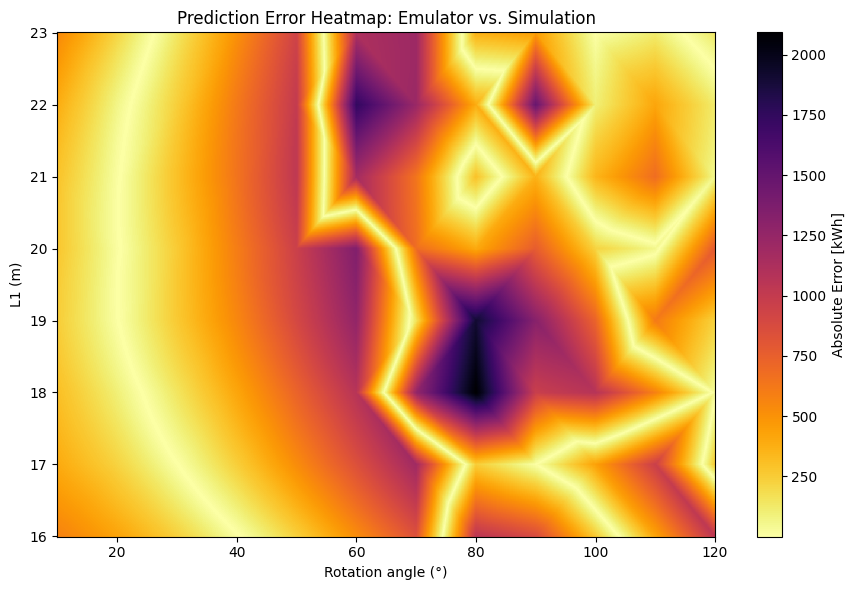

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Assuming poly and model are already defined from the previous polynomial regression
def predict_surface(rotation, L1):
    pts = np.column_stack([rotation.ravel(), L1.ravel()])
    pts2 = poly.transform(pts)
    return model.predict(pts2).reshape(rotation.shape)


# Using the real dataset
df = pd.read_excel("dataset.xlsx")

# Setting up the grid
r_lin = np.linspace(10, 120, 1111)     # rotation values
L_lin = np.linspace(16, 23, 701)       # L1 values
R, L = np.meshgrid(r_lin, L_lin)

# Predicting over the full grid
Z_pred = predict_surface(R, L)

# Preparing the true data for comparison
from scipy.interpolate import griddata
points = df[["rotation", "L1"]].values
values = df["radiation"].values

# Interpolating actual irradiation over the same grid
Z_true = griddata(points, values, (R, L), method='linear')

# Computing absolute error where both prediction and actual values are valid
error_map = np.abs(Z_pred - Z_true)
mask = np.isnan(Z_true)

# Masking missing values
error_map[mask] = np.nan

# Plotting results
plt.figure(figsize=(9, 6))
cmap = plt.cm.inferno_r
im = plt.pcolormesh(R, L, error_map, cmap=cmap, shading='auto')
cbar = plt.colorbar(im)
cbar.set_label("Absolute Error [kWh]")

plt.xlabel("Rotation angle (°)")
plt.ylabel("L1 (m)")
plt.title("Prediction Error Heatmap: Emulator vs. Simulation")
plt.tight_layout()
plt.show()


In [29]:
#choosing the best degree--------------------------

In [30]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing   import PolynomialFeatures
from sklearn.linear_model    import LinearRegression
import numpy as np

kf   = KFold(n_splits=7, shuffle=True, random_state=0)
errors = []

# Trying polynomial degrees from 1 through 5
for deg in range(1, 8):
    poly    = PolynomialFeatures(degree=deg, include_bias=True)

    # Using X as the 96×2 feature array
    X_poly  = poly.fit_transform(X)
    model   = LinearRegression()

# Performing cross-validation with 'neg_mean_squared_error', then converting to positive MSE
    cv_mse  = -cross_val_score(model, X_poly, y,
                               cv=kf,
                               scoring='neg_mean_squared_error')
    errors.append((deg, cv_mse.mean(), cv_mse.std()))

# Printing MSE results for each polynomial degree
for deg, mean_mse, std_mse in errors:
    print(f"degree={deg:>2} │ MSE={mean_mse:.1f} ±{std_mse:.1f}")


degree= 1 │ MSE=745959.2 ±213191.9
degree= 2 │ MSE=618460.7 ±131119.3
degree= 3 │ MSE=528870.2 ±176464.7
degree= 4 │ MSE=576594.5 ±157588.9
degree= 5 │ MSE=506130.3 ±192328.0
degree= 6 │ MSE=696998.2 ±290002.7
degree= 7 │ MSE=840371.1 ±467558.7


In [31]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing   import PolynomialFeatures
from sklearn.linear_model    import LinearRegression
import numpy as np

kf     = KFold(n_splits=7, shuffle=True, random_state=0)
results = []

# Try polynomial degrees from 1 through 7
for deg in range(1, 8):
    # 1) Build polynomial features of degree `deg`
    poly    = PolynomialFeatures(degree=deg, include_bias=True)
    X_poly  = poly.fit_transform(X)      # X is your (96×2) array
    model   = LinearRegression()
    
    # 2) Cross‐validated MSE (negated, so take negative to get positive MSE)
    cv_mse_neg = cross_val_score(
        model, X_poly, y, 
        cv=kf, 
        scoring='neg_mean_squared_error'
    )
    cv_mse     = -cv_mse_neg  # convert to positive MSE
    
    # 3) Cross‐validated R² (already returns positive R² scores)
    cv_r2 = cross_val_score(
        model, X_poly, y,
        cv=kf,
        scoring='r2'
    )
    
    # 4) Record mean ± std of both metrics
    results.append((
        deg,
        cv_mse.mean(),  cv_mse.std(),
        cv_r2.mean(),   cv_r2.std()
    ))

# 5) Print out degree, MSE (mean±std), and R² (mean±std)
print("degree │     MSE (mean ± std)     │      R² (mean ± std)")
print("-------------------------------------------------------------")
for deg, mse_mean, mse_std, r2_mean, r2_std in results:
    print(
        f"  {deg:>2}   │  {mse_mean:10.1f} ± {mse_std:7.1f}  │  {r2_mean:7.3f} ± {r2_std:6.3f}"
    )


degree │     MSE (mean ± std)     │      R² (mean ± std)
-------------------------------------------------------------
   1   │    745959.2 ± 213191.9  │    0.679 ±  0.096
   2   │    618460.7 ± 131119.3  │    0.737 ±  0.049
   3   │    528870.2 ± 176464.7  │    0.774 ±  0.074
   4   │    576594.5 ± 157588.9  │    0.752 ±  0.069
   5   │    506130.3 ± 192328.0  │    0.785 ±  0.073
   6   │    696998.2 ± 290002.7  │    0.703 ±  0.116
   7   │    840371.1 ± 467558.7  │    0.642 ±  0.211


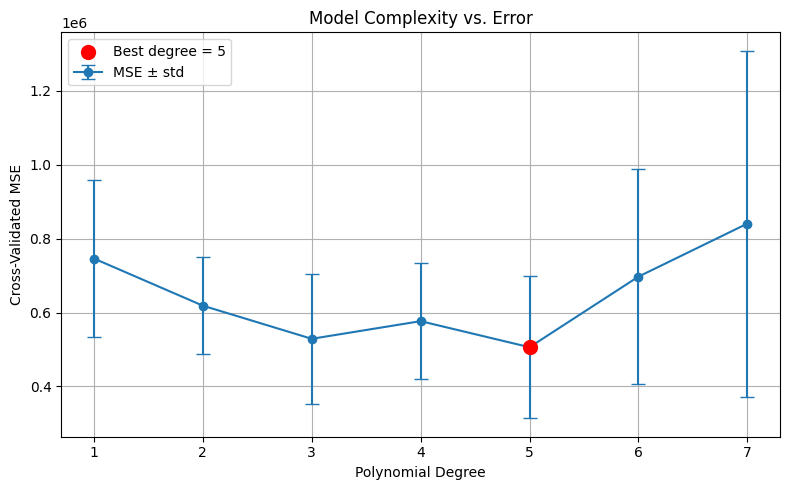

In [32]:
import matplotlib.pyplot as plt

# Assuming errors from the loop contain tuples: (degree, mean_mse, std_mse)
degrees = [deg for deg, _, _ in errors]
mse_means = [mean for _, mean, _ in errors]
mse_stds = [std for _, _, std in errors]

# Identifying the best polynomial degreee
best_idx = mse_means.index(min(mse_means))
best_degree = degrees[best_idx]

# Plotting the results
plt.figure(figsize=(8, 5))
plt.errorbar(degrees, mse_means, yerr=mse_stds, fmt='-o', capsize=5, label="MSE ± std")
plt.scatter(best_degree, mse_means[best_idx], color='red', s=100, zorder=5, label=f"Best degree = {best_degree}")

# Adding labels and title to the plot
plt.xlabel("Polynomial Degree")
plt.ylabel("Cross-Validated MSE")
plt.title("Model Complexity vs. Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


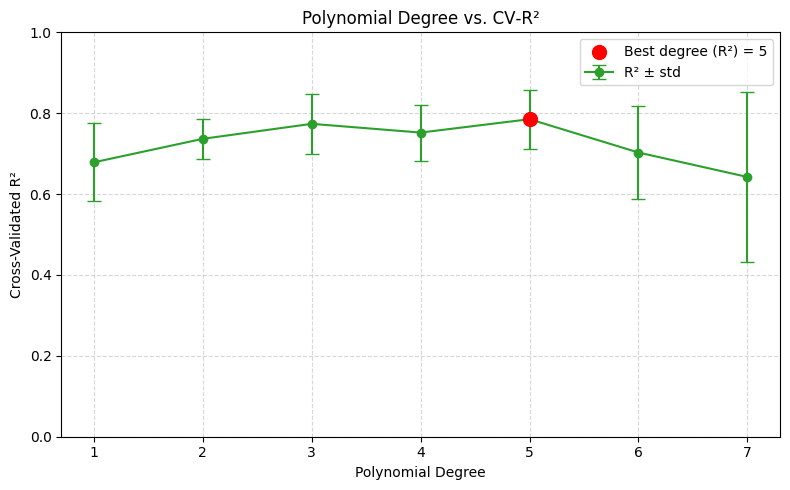

In [33]:
# plotting the R2 for each model


import matplotlib.pyplot as plt


# Extracting degree, R² means, and R² stds
degrees = [t[0] for t in results]
r2_means = [t[3] for t in results]
r2_stds  = [t[4] for t in results]

# Identifing the degree with highest mean R²
best_idx    = r2_means.index(max(r2_means))
best_degree = degrees[best_idx]

# Plot R² vs. polynomial degree with error bars
plt.figure(figsize=(8, 5))
plt.errorbar(
    degrees,              # x-axis: polynomial degrees
    r2_means,             # y-axis: mean R²
    yerr=r2_stds,         # error bars: ± one std
    fmt='-o',             # line with circle markers
    capsize=5,            # length of error bar caps
    color='C2',           # choose a distinct color (green)
    label="R² ± std"
)

# Highlighting the best degree
plt.scatter(
    best_degree,
    r2_means[best_idx],
    color='red',
    s=100,
    zorder=5,
    label=f"Best degree (R²) = {best_degree}"
)

# Adding labels and title
plt.xlabel("Polynomial Degree")
plt.ylabel("Cross‐Validated R²")
plt.title("Polynomial Degree vs. CV‐R²")
plt.xticks(degrees)          # ensure x-axis ticks show each degree
plt.ylim(0, 1.0)             # R² ranges from 0 to 1
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


In [34]:
# Noting that the best degree is 5

In [35]:
# Remodeling using degree 5

In [36]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Loading the dataset
df = pd.read_excel("dataset.xlsx")

# Extracting the feature matrix X (rotation, L1) and target y (radiation)
X = df[["rotation", "L1"]].values
y = df["radiation"].values

In [37]:
# Expanding to 5th-degree terms: 1, r, L, r², rL, L², ..., up to all combinations including r⁵ and L⁵
poly5 = PolynomialFeatures(degree=5, include_bias=True)
X5 = poly5.fit_transform(X)

In [38]:
model5 = LinearRegression()
model5.fit(X5, y)


LinearRegression()

In [39]:
# Calculating baseline SSE using the mean predictor
y_mean = y.mean()
sse_initial = np.sum((y - y_mean) ** 2)

# Calculating SSE using the fitted model
y_pred5 = model5.predict(X5)
sse_optimized = np.sum((y - y_pred5) ** 2)

print(f"Initial SSE (mean):      {sse_initial:.2f}")
print(f"Optimized SSE (deg 5):   {sse_optimized:.2f}")
print(f"SSE reduction:           {100*(sse_initial - sse_optimized)/sse_initial:.1f}%")


Initial SSE (mean):      257355185.19
Optimized SSE (deg 5):   29273900.39
SSE reduction:           88.6%


In [40]:
# Getting feature names in polynomial order
feat_names = poly5.get_feature_names_out(["rotation", "L1"])

# Pairing feature names with their corresponding coefficients
for name, coeff in zip(feat_names, model5.coef_):
    print(f"{name:>12s} : {coeff:.6g}")
print(f"{'intercept':>12s} : {model5.intercept_:.6g}")


           1 : 0
    rotation : -21662.2
          L1 : -403.172
  rotation^2 : 144.619
 rotation L1 : 3882.05
        L1^2 : -4124.2
  rotation^3 : -1.04556
rotation^2 L1 : -13.7902
rotation L1^2 : -271.188
        L1^3 : 414.82
  rotation^4 : 0.00463842
rotation^3 L1 : 0.0522859
rotation^2 L1^2 : 0.471958
rotation L1^3 : 8.636
        L1^4 : -15.627
  rotation^5 : -9.00993e-06
rotation^4 L1 : -9.08388e-05
rotation^3 L1^2 : -0.000764533
rotation^2 L1^3 : -0.00557207
rotation L1^4 : -0.105027
        L1^5 : 0.209384
   intercept : 177508


In [41]:
# Getting feature names and coefficients
feature_names = poly5.get_feature_names_out(["rotation", "L1"])
coefficients = model5.coef_
intercept = model5.intercept_

# Building the polynomial equation string
terms = []

for name, coeff in zip(feature_names, coefficients):
    if abs(coeff) < 1e-5:
        continue  # Skipping near-zero terms for better readability
    term_str = f"{coeff:.4f}*{name}"
    terms.append(term_str)

# Adding the intercept to the equation
equation = f"f(rotation, L1) = {intercept:.4f} + " + " + ".join(terms)

# Printing the full equation
print("Full regression equation:\n")
print(equation)


Full regression equation:

f(rotation, L1) = 177507.6507 + -21662.1816*rotation + -403.1717*L1 + 144.6188*rotation^2 + 3882.0529*rotation L1 + -4124.1984*L1^2 + -1.0456*rotation^3 + -13.7902*rotation^2 L1 + -271.1885*rotation L1^2 + 414.8196*L1^3 + 0.0046*rotation^4 + 0.0523*rotation^3 L1 + 0.4720*rotation^2 L1^2 + 8.6360*rotation L1^3 + -15.6270*L1^4 + -0.0001*rotation^4 L1 + -0.0008*rotation^3 L1^2 + -0.0056*rotation^2 L1^3 + -0.1050*rotation L1^4 + 0.2094*L1^5


In [42]:
def surface5(rotation, L1):
    pts = np.column_stack([rotation.ravel(), L1.ravel()])
    vals = model5.predict(poly5.transform(pts))
    return vals.reshape(rotation.shape)

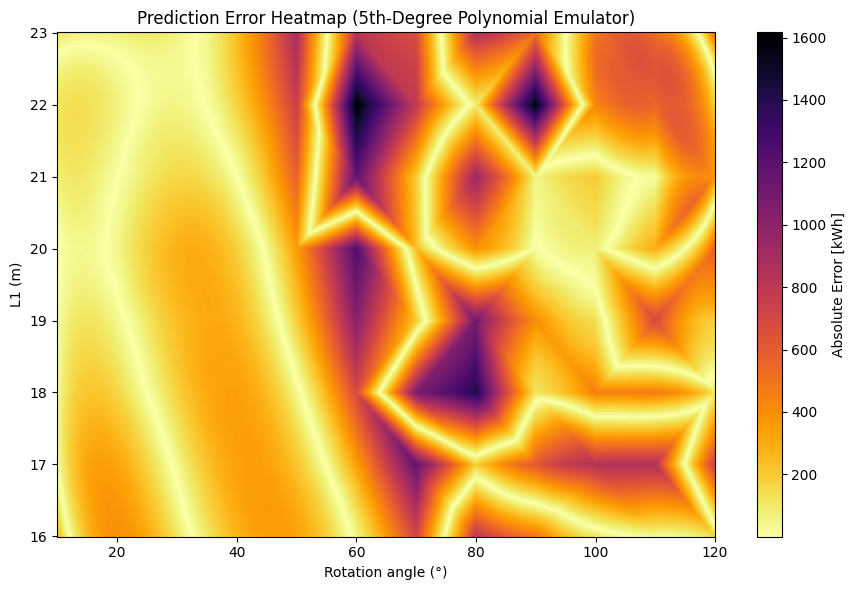

In [43]:
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Defining the grid range for rotation and L1
r_lin = np.linspace(10, 120, 1111)
L_lin = np.linspace(16, 23, 701)
R, L = np.meshgrid(r_lin, L_lin)

# Predicting over the mesh using the trained model
Z_pred5 = surface5(R, L)

# Interpolating actual radiation data onto the same grid
points = df[["rotation", "L1"]].values
values = df["radiation"].values
Z_true = griddata(points, values, (R, L), method='linear')

# Computing the absolute error between predicted and actual values
error_map5 = np.abs(Z_pred5 - Z_true)
error_map5[np.isnan(Z_true)] = np.nan

# Plotting the error map
plt.figure(figsize=(9, 6))
cmap = plt.cm.inferno_r
im = plt.pcolormesh(R, L, error_map5, cmap=cmap, shading='auto')
cbar = plt.colorbar(im)
cbar.set_label("Absolute Error [kWh]")

plt.xlabel("Rotation angle (°)")
plt.ylabel("L1 (m)")
plt.title("Prediction Error Heatmap (5th-Degree Polynomial Emulator)")
plt.tight_layout()
plt.show()


In [44]:
def surface_eq_5(r, L):
    return (
        177502.4349
        - 21661.8742 * r
        - 403.1559 * L
        + 144.6189 * r**2
        + 3881.9884 * r * L
        - 4124.0603 * L**2
        - 1.0456 * r**3
        - 13.7902 * r**2 * L
        - 271.1835 * r * L**2
        + 414.8053 * L**3
        + 0.0046 * r**4
        + 0.0523 * r**3 * L
        + 0.4720 * r**2 * L**2
        + 8.6358 * r * L**3
        - 15.6265 * L**4
        - 0.0001 * r**4 * L
        - 0.0008 * r**3 * L**2
        - 0.0056 * r**2 * L**3
        - 0.1050 * r * L**4
        + 0.2094 * L**5
    )
# Performing a quick prediction check at a known configuration
# Verifying closeness to the actual radiation for (20°, 20m)



# Computing the polynomial’s prediction at (20,20)
poly_pred = surface_eq_5(20, 20)

# 2) Look up the measured radiation in df
measured_row = df.loc[
    (df["rotation"] == 20) & (df["L1"] == 20),
    "radiation"
]
if not measured_row.empty:
    measured_rad = measured_row.values[0]
else:
    measured_rad = None

# 3) Print both for comparison
print(f"Polynomial prediction at (20°, 20 m): {poly_pred:.4f} kWh")
if measured_rad is not None:
    print(f"Measured radiation   at (20°, 20 m): {measured_rad:.4f} kWh")
else:
    print("No matching measured row found for (20°, 20 m).")


Polynomial prediction at (20°, 20 m): 6900.6329 kWh
Measured radiation   at (20°, 20 m): 6909.3778 kWh


In [45]:
# Creating a fine mesh grid within the input bounds
r_lin = np.linspace(10, 120, 1101)   # step ~0.1°
L_lin = np.linspace(16, 23, 701)     # step ~0.01

R, L = np.meshgrid(r_lin, L_lin)
Z5 = surface5(R, L)

# Locating the maximum predicted radiation on the grid
idx = np.unravel_index(np.argmax(Z5), Z5.shape)
r_opt5, L_opt5 = R[idx], L[idx]
rad_opt5   = Z5[idx]

print(f"Optimal rotation = {r_opt5:.2f}°, L1 = {L_opt5:.2f} → irradiation ≈ {rad_opt5:.1f}")


Optimal rotation = 10.00°, L1 = 23.00 → irradiation ≈ 7435.3


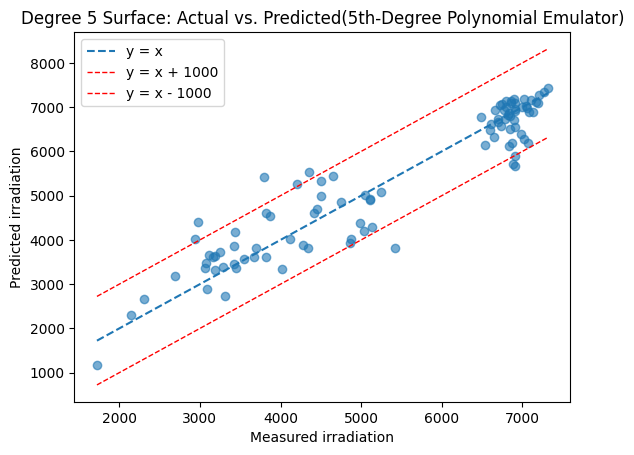

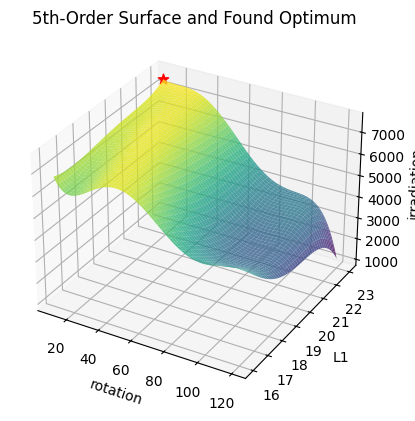

In [46]:
# Plotting actual vs. predicted values on the training dataset
plt.figure()
plt.scatter(y, y_pred5, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], linestyle="--", label="y = x")

# Adding 3 dashed reference lines: y = x, y = x + 1500, y = x - 1500
line = np.linspace(y.min(), y.max(), 100)
plt.plot(line, line + 1000, 'r--', linewidth=1, label="y = x + 1000")
plt.plot(line, line - 1000, 'r--', linewidth=1, label="y = x - 1000")
plt.xlabel("Measured irradiation")
plt.ylabel("Predicted irradiation")
plt.title("Degree 5 Surface: Actual vs. Predicted(5th-Degree Polynomial Emulator)")
plt.legend()
plt.show()

# Creating a 3D surface plot with the optimum point highlighted
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax  = fig.add_subplot(111, projection="3d")
ax.plot_surface(R, L, Z5, cmap="viridis", edgecolor="none", alpha=0.8)
ax.scatter(r_opt5, L_opt5, rad_opt5, color="red", s=60, marker="*")
ax.set_xlabel("rotation")
ax.set_ylabel("L1")
ax.set_zlabel("irradiation")
plt.title("5th-Order Surface and Found Optimum")
plt.show()


In [47]:
#optimization

In [48]:
from scipy.optimize import minimize

def obj_to_target(x):
    """
    x[0] = rotation angle r, x[1] = window length L1.
    Returns (predicted_radiation – 6000)^2.
    """
    r, L1 = x
    # evaluating the surrogate model at (r, L1)
    val = surface5(np.array([[r]]), np.array([[L1]]))[0, 0]
    # return the squared error relative to our 6000 kWh goal
    return (val - 6000)**2


In [49]:
# starting from the global maximum found earlier 
x0 = np.array([r_opt, L_opt])


In [50]:
bounds = [(10.0, 120.0),  # rotation angle must lie between 10 and 120 degree
          (16.0,  23.0)]  # L1 length must lie between 16 m and 23 m

# Performing the optimization using the Powell method
result_target = minimize(
    fun=obj_to_target,
    x0=x0,                  # initial guess for [r, L1]
    method="Powell",        
    bounds=bounds,          # enforcing variable limits
    options={"xtol": 1e-3, "ftol": 1e-3, "disp": True}  #setting tolerance for changes in r, L1 and the objective value 
)


Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 3
         Function evaluations: 92


In [51]:
# Checking if the optimizer converged successfully
if result_target.success:
    # Extracting the optimal rotation angle and L1 length
    r_target, L1_target = result_target.x
    
    # Evaluating the surrogate model at the optimal point
    rad_target = surface5(
        np.array([[r_target]]),
        np.array([[L1_target]])
    )[0, 0]
    
    # Printing the results in a readable format
    print(f"Converged: rotation = {r_target:.2f}°, L1 = {L1_target:.2f}")
    print(f"  Predicted radiation = {rad_target:.2f} kWh")
    print(f"  Error squared      = {obj_to_target([r_target, L1_target]):.4f}")
else:
    # Report failure and the solver’s message
    print("Optimization failed:", result_target.message)


Converged: rotation = 53.15°, L1 = 22.13
  Predicted radiation = 6000.00 kWh
  Error squared      = 0.0000


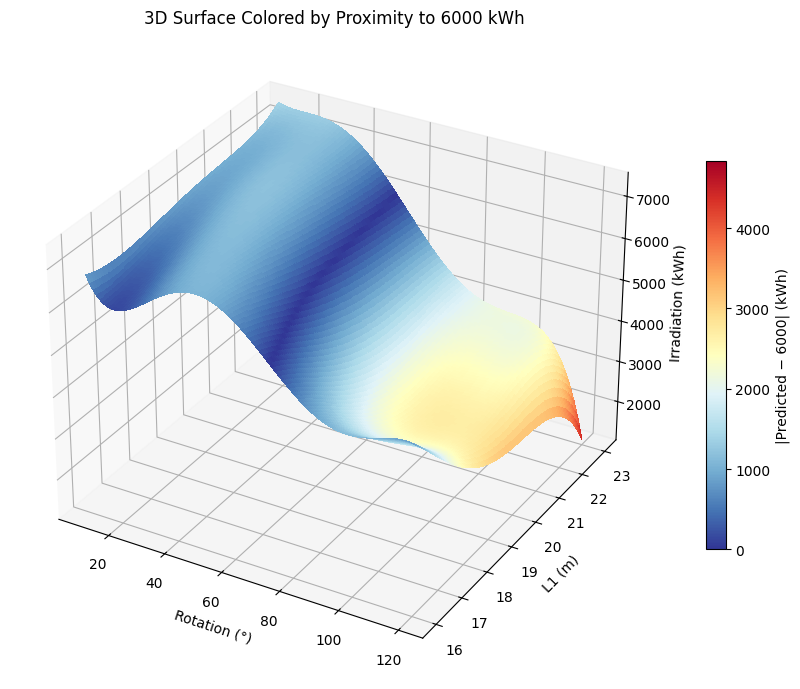

In [52]:
# printing the 3D 5th degree emulator with the realtive color showcasing the error (predicted-6000kWh)

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Helper to evaluate the 5th-order surface
def surface5(rotation, L1):
    pts    = np.column_stack([rotation.ravel(), L1.ravel()])
    X5_pts = poly5.transform(pts)   # poly5 defined earlier
    vals   = model5.predict(X5_pts) # model5 defiend earlier
    return vals.reshape(rotation.shape)

# Build a fine grid over your domain
r_lin = np.linspace(10, 120, 100)   # 100 steps from 10 to 120 degree
L_lin = np.linspace(16,  23, 100)   # 100 steps from 16 m to 23 m
R, L  = np.meshgrid(r_lin, L_lin)

# Compute the absolute error from the 6000 W/m² target
Z_error = np.abs(surface5(R, L) - 6000.0)

# Normalizing the error for coloring (0 → rBlue, max error → red)
norm   = plt.Normalize(vmin=0, vmax=Z_error.max())
colors = plt.cm.RdYlBu_r(norm(Z_error))

# Plotting the 3D surface with facecolors set by error
fig = plt.figure(figsize=(10, 7))
ax  = fig.add_subplot(111, projection='3d')
ax.plot_surface(
    R, L, surface5(R, L),
    facecolors=colors,
    rcount=100, ccount=100,
    linewidth=0, antialiased=False, shade=False
)

# Adding a colorbar keyed to the error
mappable = plt.cm.ScalarMappable(cmap='RdYlBu_r', norm=norm)
mappable.set_array(Z_error)
fig.colorbar(mappable, ax=ax, shrink=0.6, label='|Predicted − 6000| (kWh)')

# Labeling and titling
ax.set_xlabel('Rotation (°)')
ax.set_ylabel('L1 (m)')
ax.set_zlabel('Irradiation (kWh)')
ax.set_title('3D Surface Colored by Proximity to 6000 kWh')

plt.tight_layout()
plt.show()


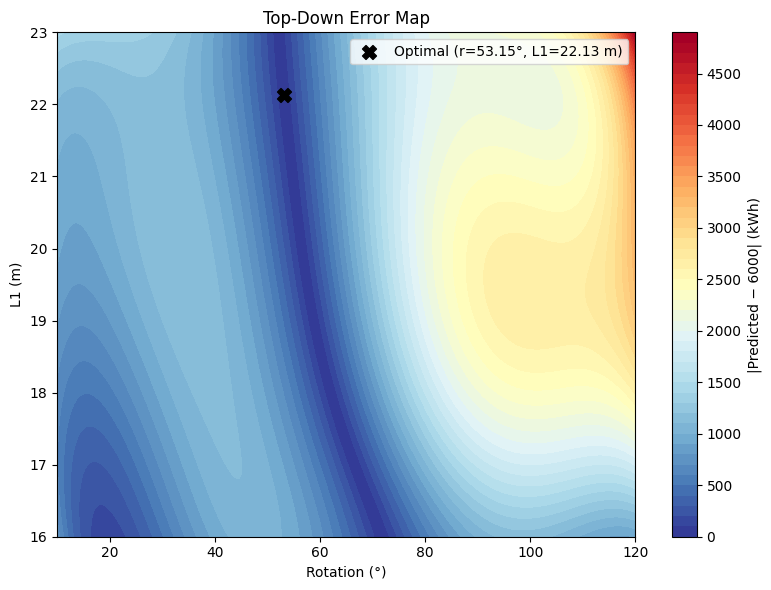

In [53]:

#Top-Down error map 

import numpy as np
import matplotlib.pyplot as plt

# Building a fine grid over your domain
r_lin = np.linspace(10, 120, 400)   # 400 points from 10 to 120 degree
L_lin = np.linspace(16, 23,  300)   # 300 points from 16 m to 23 m
R, L = np.meshgrid(r_lin, L_lin)

# Computing absolute error from the 6000 kWh target
Z = np.abs(surface5(R, L) - 6000.0)

#  Making a filled contour plot (top-down view)
plt.figure(figsize=(8, 6))
contours = plt.contourf(
    R, L, Z,
    levels=50,            # number of contour levels
    cmap="RdYlBu_r",      # Blue=low error, red=high error
    vmax=Z.max(),         # scale max to the largest error
    vmin=0                # zero error is the coldest color
)
plt.colorbar(contours, label="|Predicted − 6000| (kWh)")

# Marking the optimal point
plt.scatter(
    r_target, L1_target,
    color="black", s=100, marker="X",
    label=f"Optimal (r={r_target:.2f}°, L1={L1_target:.2f} m)"
)

# Labels and title
plt.xlabel("Rotation (°)")
plt.ylabel("L1 (m)")
plt.title("Top-Down Error Map")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


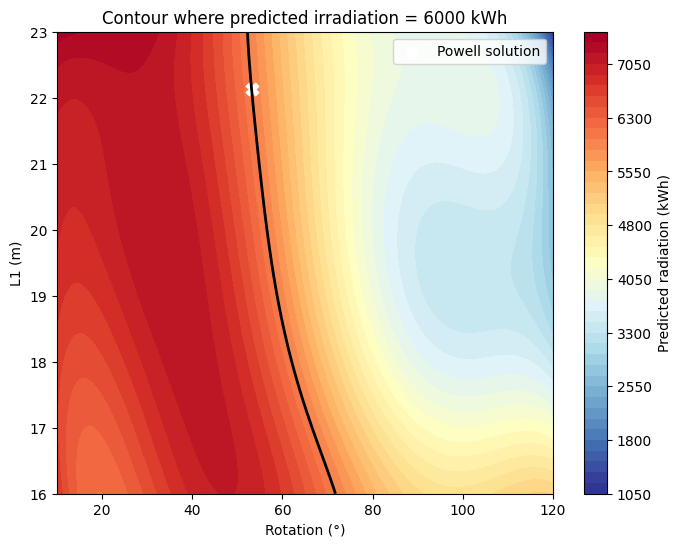

In [54]:
#representation of a curve that the predicted irradiation falls below the predefined threhshold

import numpy as np
import matplotlib.pyplot as plt

# Recreating the grid
r_lin = np.linspace(10, 120, 400)
L_lin = np.linspace(16,  23, 300)
R, L = np.meshgrid(r_lin, L_lin)

# Evaluating the surrogate on the grid
Z = surface5(R, L)

# Use contour() to find the 6000 contour line
fig, ax = plt.subplots(figsize=(8,6))
CS = ax.contour(R, L, Z, levels=[6000], colors='black', linewidths=2)

# (Optional) Fill regions inside/outside
cf = ax.contourf(R, L, Z, levels=50, cmap='RdYlBu_r', vmin=Z.min(), vmax=Z.max())

# Marking the single “optimal” point you found earlier
ax.scatter(r_target, L1_target, color='white', s=80, marker='X', label='Powell solution')

# Labels and legend
ax.set_xlabel('Rotation (°)')
ax.set_ylabel('L1 (m)')
ax.set_title('Contour where predicted irradiation = 6000 kWh')
ax.legend()
plt.colorbar(cf, label='Predicted radiation (kWh)')
plt.show()


In [55]:
#------------ Finding the curve equation------------

In [56]:
poly5   = PolynomialFeatures(degree=5, include_bias=True)
X5      = poly5.fit_transform(X)     # X is your original (rotation, L1) array
model5  = LinearRegression().fit(X5, y)


In [57]:
feature_names = poly5.get_feature_names_out(["rotation", "L1"])
coeffs        = model5.coef_          # length = 21
intercept     = model5.intercept_     # a single float


In [58]:
# Starting by taking the intercept and subtracting 6000
adjusted_intercept = intercept - 6000.0

# Assemble each monomial term that has a non‐negligible coefficient
terms = []
# Including the adjusted constant if it’s not essentially zero
if abs(adjusted_intercept) > 1e-8:
    terms.append(f"{adjusted_intercept:.6g}")

for name, c in zip(feature_names, coeffs):
    if name == "1":
        continue    # skip the original intercept (we already handled it)
    if abs(c) < 1e-8:
        continue    # skip near‐zero coefficients for readability
    
    # Format each coefficient with sign
    sign = "+" if c >= 0 else "-"
    coeff_str = f"{abs(c):.6g}"       # e.g. "4.08447"
    var_str   = name.replace("rotation", "r").replace("L1", "L1")
    
    terms.append(f" {sign} {coeff_str}*{var_str}")

# Joining everything into one equation string: "… = 0"
equation_str = " ".join(terms) + " = 0"

print("Implicit level‐set equation (hat f(r,L1) = 6000):\n")
print(equation_str)


Implicit level‐set equation (hat f(r,L1) = 6000):

171508  - 21662.2*r  - 403.172*L1  + 144.619*r^2  + 3882.05*r L1  - 4124.2*L1^2  - 1.04556*r^3  - 13.7902*r^2 L1  - 271.188*r L1^2  + 414.82*L1^3  + 0.00463842*r^4  + 0.0522859*r^3 L1  + 0.471958*r^2 L1^2  + 8.636*r L1^3  - 15.627*L1^4  - 9.00993e-06*r^5  - 9.08388e-05*r^4 L1  - 0.000764533*r^3 L1^2  - 0.00557207*r^2 L1^3  - 0.105027*r L1^4  + 0.209384*L1^5 = 0


In [59]:
import numpy as np

# Defining the helper again
def surface5(rotation, L1):
    pts    = np.column_stack([rotation.ravel(), L1.ravel()])
    X5_pts = poly5.transform(pts)   
    vals   = model5.predict(X5_pts) 
    return vals.reshape(rotation.shape)

# Create a dense mesh over (r,L1)
r_lin = np.linspace(10, 120, 400)   # 400 points from 10° to 120°
L_lin = np.linspace(16,  23, 300)   # 300 points from 16 m to 23 m
R, L  = np.meshgrid(r_lin, L_lin)

# Evaluate the surrogate on that mesh
Z = surface5(R, L)


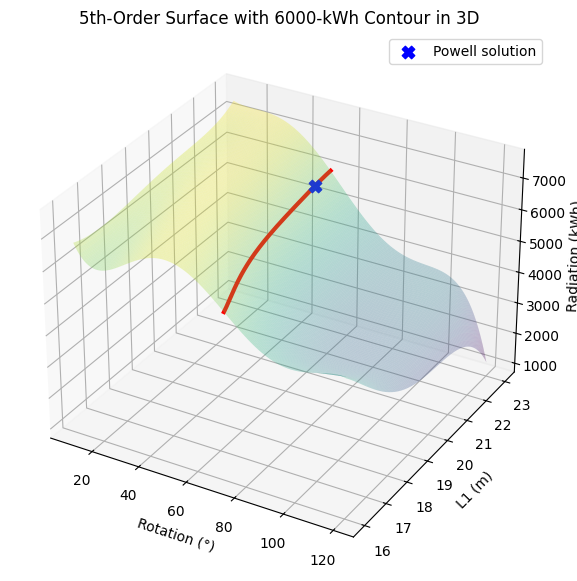

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# (Re‐define surface5 if needed)
def surface5(rotation, L1):
    pts    = np.column_stack([rotation.ravel(), L1.ravel()])
    X5_pts = poly5.transform(pts)   
    vals   = model5.predict(X5_pts) 
    return vals.reshape(rotation.shape)

# Building a dense grid over (rotation, L1)
r_lin = np.linspace(10, 120, 400)   # 400 points from 10° to 120°
L_lin = np.linspace(16,  23, 300)   # 300 points from 16 m to 23 m
R, L   = np.meshgrid(r_lin, L_lin)

# Evaluating the surrogate on that grid
Z = surface5(R, L)

# Finding the contour(s) at level = 6000 using a temporary 2D plot
fig2d, ax2d = plt.subplots()
CS = ax2d.contour(R, L, Z, levels=[6000], colors='black', linewidths=2)

# Extract the raw segments from CS.allsegs
#    CS.allsegs is a list of lists: allsegs[0] contains one list per contour segment at level 6000.
contour_segments = CS.allsegs[0]  

# Closing the 2D figure since we only needed it to compute the segments
plt.close(fig2d)

# Now plot in 3D: the full surface plus the 6000‐level curve(s)
fig3d = plt.figure(figsize=(10, 7))
ax3d  = fig3d.add_subplot(111, projection='3d')

# Ploting the semi-transparent 5th-order surface for context
surf = ax3d.plot_surface(
    R, L, Z,
    rcount=100, ccount=100,
    alpha=0.3,            # make it mostly transparent
    cmap='viridis',
    linewidth=0
)

# Overlaying each contour segment as a red 3D line at z = 6000
for seg in contour_segments:
    r_line = seg[:, 0]
    L_line = seg[:, 1]
    z_line = np.full_like(r_line, 6000.0)
    ax3d.plot(r_line, L_line, z_line, color='red', linewidth=3, label='_nolegend_')

# Marking the single Powell‐found solution point, also at z=6000
ax3d.scatter(
    r_target, L1_target, 6000.0,
    color='blue', s=80, marker='X',
    label='Powell solution'
)

# Labels, title, and viewing angle
ax3d.set_xlabel('Rotation (°)')
ax3d.set_ylabel('L1 (m)')
ax3d.set_zlabel('Radiation (kWh)')
ax3d.set_title('5th-Order Surface with 6000-kWh Contour in 3D')
ax3d.view_init(elev=30, azim=-60)
ax3d.legend(loc='upper right')

plt.show()


In [61]:
#-------------- analysing the roation and length effect

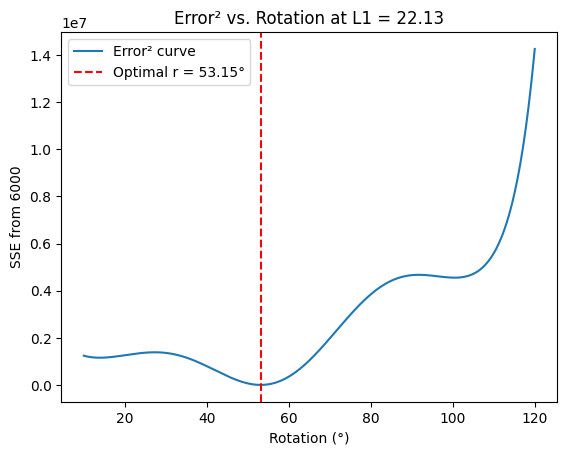

In [62]:
# Creating a range of rotation angles (10° to 120°) finxing the optimal length of  L1=22.13
r_test = np.linspace(10, 120, 500)

# For each r, compute SSE = (prediction – 6000)², holding L1 fixed at L1_target
err_slice = [
    (surface5(np.array([[r]]), np.array([[L1_target]]))[0, 0] - 6000) ** 2
    for r in r_test
]

# Plotting  error² vs. rotation, and mark the optimal rotation
plt.figure()
plt.plot(r_test, err_slice, label="Error² curve")
plt.axvline(r_target, color="red", linestyle="--", label=f"Optimal r = {r_target:.2f}°")
plt.xlabel("Rotation (°)")
plt.ylabel("SSE from 6000")
plt.title(f"Error² vs. Rotation at L1 = {L1_target:.2f}")
plt.legend()
plt.show()


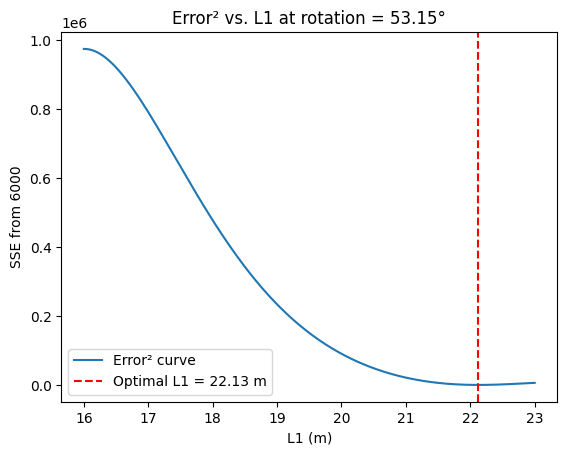

In [63]:
# Defining a range of L1 values from 16 m to 23 m fixing the optimal rotation  r=53.15
L1_test = np.linspace(16, 23, 500)   # ~0.014 m increments

# For each L1, compute SSE = (prediction – 6000)² with rotation fixed at r_target
err_slice_L1 = [
    (surface5(
        np.array([[r_target]]),
        np.array([[L1]])
    )[0, 0] - 6000.0) ** 2
    for L1 in L1_test
]

# Ploting SSE vs. L1 and mark the optimal L1
plt.figure()
plt.plot(L1_test, err_slice_L1, label="Error² curve")
plt.axvline(
    L1_target,
    color="red",
    linestyle="--",
    label=f"Optimal L1 = {L1_target:.2f} m"
)
plt.xlabel("L1 (m)")
plt.ylabel("SSE from 6000")
plt.title(f"Error² vs. L1 at rotation = {r_target:.2f}°")
plt.legend()
plt.show()


In [64]:
# rewriting the 5th-degree equation of the polynomial surrogate model with all the coefficients and variables.


# Choosing coefficient source
if hasattr(model5, "coef_"):
    # closed-form linear model
    coeffs   = model5.coef_
    intercept = model5.intercept_
else:
    # iterative Powell result
    coeffs   = coeff_opt
    # find constant term index in feat_names
    idx0     = list(feat_names).index("1")
    intercept = coeffs[idx0]

# Building terms
terms = []
for name, c in zip(feat_names, coeffs):
    if name == "1":
        continue      
    sign = "+" if c >= 0 else "-"
    coeff_str = f"{abs(c):.6g}"
    var_str   = name.replace("rotation", "r")
    terms.append(f" {sign} {coeff_str}*{var_str}")

# Assembling full equation string
eqn = f"f(r,L1) = {intercept:.6g}" + "".join(terms)

print("\nComplete surrogate equation:\n")
print(eqn)



Complete surrogate equation:

f(r,L1) = 177508 - 21662.2*r - 403.172*L1 + 144.619*r^2 + 3882.05*r L1 - 4124.2*L1^2 - 1.04556*r^3 - 13.7902*r^2 L1 - 271.188*r L1^2 + 414.82*L1^3 + 0.00463842*r^4 + 0.0522859*r^3 L1 + 0.471958*r^2 L1^2 + 8.636*r L1^3 - 15.627*L1^4 - 9.00993e-06*r^5 - 9.08388e-05*r^4 L1 - 0.000764533*r^3 L1^2 - 0.00557207*r^2 L1^3 - 0.105027*r L1^4 + 0.209384*L1^5


In [65]:
# Testing the obtained (r,L1) values for irradiation of 6000 to make sure if the result of equation outcome with a value close to 6000 or not. 


def predict_radiation(r, L1):
    """
    r  : rotation angle (°)
    L1 : length (m)
    returns: predicted radiation from the 5th-order surface
    """
    # Building a 1×2 feature array
    X_new = [[r, L1]]
    # Transforming to 1×21 polynomial features
    X5_new = poly5.transform(X_new)
    # Predicting and return the scalar
    return model5.predict(X5_new)[0]

# Example usage: (53.15°,22.13m)  in the (X,Y) X= rotation and Y= length
print(predict_radiation(53.15, 22.13))   

5999.921819884155


In [66]:
import numpy as np
import pandas as pd

# give your desirable values to "r" and "L1" in the predefined range (10<r<120 and 16<L1<23)and get the calculated result of the 5th degree polyminal surrougate model. 
# the code automatically read the closest value for r and L1 that present in the dataset and provide you with the real original irradiation. 

def predict_and_lookup(r, L1, target_df):
    """
    r, L1        : floats, the user-specified rotation and length
    target_df    : pandas DataFrame with columns ['rotation', 'L1', 'radiation']
    
    returns: dict with
      'r', 'L1', 'predicted'      : your surrogate result
      'r_nn', 'L1_nn', 'measured' : the nearest measured point in the dataset
    """
    # 1. Surrogate prediction
    X_new    = [[r, L1]]
    X5_new   = poly5.transform(X_new)
    pred_rad = model5.predict(X5_new)[0]
    
    #-----------------------

    # 2. Nearest-neighbor lookup in the measured data
    #    compute squared Euclidean distance to each row
    d2 = (target_df['rotation'] - r)**2 + (target_df['L1'] - L1)**2
    idx = d2.idxmin()
    
    r_nn         = target_df.at[idx, 'rotation']
    L1_nn        = target_df.at[idx, 'L1']
    measured_rad = target_df.at[idx, 'radiation']
    
    return {
        'r': r,
        'L1': L1,
        'predicted': pred_rad,
        'r_nn': r_nn,
        'L1_nn': L1_nn,
        'measured': measured_rad
    }

# Example usage:
df = pd.read_excel("dataset.xlsx")

#////////////************  INSERT YOUR ROTATION AND LENGTH HERE: (ROTATION, L1 LENGTH) *************///////

result = predict_and_lookup(32.4, 22.8, df)

#------------------------------

print("\n***** base on 5th degree polynomial surrogate model ***** \n")
print(f"Input:         r = {result['r']:.2f}, L1 = {result['L1']:.2f}")
print(f"Predicted irradiation: {result['predicted']:.2f} kWh")
print("\n***** nearest measured point (real dataset) ***** \n")
print(f"Measured at:   r = {result['r_nn']:.2f}, L1 = {result['L1_nn']:.2f}")
print(f"Measured irradiation:  {result['measured']:.2f} kWh")



***** base on 5th degree polynomial surrogate model ***** 

Input:         r = 32.40, L1 = 22.80
Predicted irradiation: 7176.04 kWh

***** nearest measured point (real dataset) ***** 

Measured at:   r = 30.00, L1 = 23.00
Measured irradiation:  7204.25 kWh
